In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats import weightstats 

In [2]:
catawba = pd.read_csv("../data/catawba_05_22.csv")
kentland = pd.read_csv("../data/kentland_10_22.csv")

In [3]:
diam_all = pd.concat([catawba[['diam_app','diam','species','site']],kentland[['diam_app','diam','species','site']]]).reset_index(drop = True)
# height_all = pd.concat([catawba[['height_app','height','species','site']],kentland[['height_app','height','species','site']]]).reset_index(drop = True)

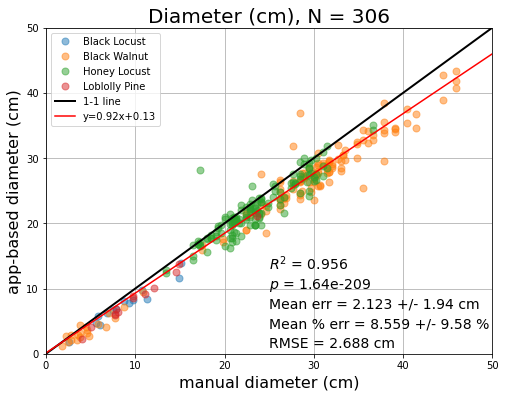

In [4]:
# Diam linear regression grouped by species 

groups = diam_all.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['diam'], group['diam_app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_all['diam'], diam_all['diam_app'])

# Mean absolute error
mae = np.nanmean(abs(diam_all['diam'] - diam_all['diam_app']))
mae_std = np.nanstd((diam_all['diam'] - diam_all['diam_app']))
mape = np.nanmean(((diam_all['diam'] - diam_all['diam_app']) / diam_all['diam'])) * 100
mape_std = np.nanstd(((diam_all['diam'] - diam_all['diam_app']) / diam_all['diam'])) * 100
rmse = ((diam_all['diam'] - diam_all['diam_app']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [25,13], size = 14)
plt.annotate("$p$ = {:.2e}".format(p_value), [25,10], size = 14)
plt.annotate("Mean err = {} +/- {} cm".format(str(round(mae,5))[:5],str(round(mae_std,2))), [25,7], size = 14)
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [25,4], size = 14)
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [25,1], size = 14)

ax.legend()
ax.set_xlim(0,50)
ax.set_ylim(0,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Diameter (cm), N = {}".format(str(len(diam_all)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

In [5]:
# Paired Sample t test - for paired data 
# H0 - the means of hte populations are equal
# HA - means of the populatons are not equal 

print(stats.ttest_rel(diam_all['diam_app'],diam_all['diam']))

Ttest_relResult(statistic=-16.674367802306982, pvalue=8.054537990286562e-45)


In [6]:
# Large T statistics indicate that the distributions are not very similar 
# The very small p values indicate that we can reject the null hypothesis that the means are equal

In [7]:
# Independent sample T test - unpaired data
# H0 - the means of hte populations are equal
# HA - means of the populatons are not equal 

print(stats.ttest_ind(diam_all['diam'],diam_all['diam_app'], equal_var = False))

# The small T statistic for diameter indicate that the distributions are very similar 
# The large p values indicates that we CANT reject the null hypothesis that the means are equal. 

Ttest_indResult(statistic=2.574439871504103, pvalue=0.010275907503194865)


In [8]:
# Wilcox Signed Rank Test - null hyp that median of the population of differences between the paired data is zero

print("SIGNED RANK TEST DIAM")
print(stats.wilcoxon(diam_all['diam'], diam_all['diam_app']))

SIGNED RANK TEST DIAM
WilcoxonResult(statistic=2325.0, pvalue=1.7441657345326328e-42)


In [9]:
# Levene tests the null hypothesis that the population variances are equal
stats.levene(diam_all['diam'], diam_all['diam_app'], center= 'mean')
# Can't reject 

# Levene tests the null hypothesis that the population variances are equal
# stats.levene(height_all['height'], height_all['height_app'], center= 'mean')
# Can't reject 

LeveneResult(statistic=1.1199503016490948, pvalue=0.2903480425178573)

In [10]:
def concordance_corr_coeff(x,y,correlation):
    numerator = 2 * correlation * np.nanstd(x) * np.nanstd(y)
    denom = np.nanstd(x)**2 + np.nanstd(y)**2  + (np.nanmean(x) - np.nanmean(y)) ** 2
    return numerator/denom

def intra_class_corr(x,y):
    N = len(x)
    x_bar = (1 / (2 * N)) * np.nansum(x+y)
    s_sq = (1 / (2 * N)) * ( np.nansum((x - x_bar)**2) + np.nansum((y - x_bar)**2) ) 
    ICC = (1 / (N * s_sq)) * np.nansum( (x-x_bar ) * (y - x_bar) )
    
    return ICC

In [11]:
print(concordance_corr_coeff(diam_all['diam'],diam_all['diam_app'],r_value))
print(intra_class_corr(diam_all['diam'],diam_all['diam_app']))

0.9554010200186038
0.9549216538578351


In [12]:
for sp in diam_all['species'].unique():
    ddf = diam_all[diam_all['species']==sp]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ddf['diam'], ddf['diam_app'])
    cc = concordance_corr_coeff(ddf['diam_app'], ddf['diam'], correlation = r_value)
    rmse = ((ddf['diam_app'] - ddf['diam']) ** 2).mean() ** .5

    print("======="*5)
    print(sp  + " N = {}".format(len(ddf)))
    print("Mean error = {}".format((ddf['diam']-ddf['diam_app']).mean()))
    print("Mean Pct error = {}".format(np.nanmean((ddf['diam']-ddf['diam_app'])/ddf['diam'])*100))
    print("R2 = {}".format(r_value**2))
    
    print("RMSE = {}".format(rmse))
    print("concordance correlation coeff = {}".format(cc))
    print("intraclass correlation coeff = {}".format(intra_class_corr(ddf['diam'],ddf['diam_app'])))
    
    
    print(stats.levene(ddf['diam'],ddf['diam_app'], center= 'mean'))
    print(stats.ttest_rel(ddf['diam'],ddf['diam_app']))
    print(stats.ttest_ind(ddf['diam'],ddf['diam_app'], equal_var = False))
    print(stats.wilcoxon(ddf['diam'],ddf['diam_app']))

Black Walnut N = 142
Mean error = 2.4880527416936347
Mean Pct error = 10.273851067684472
R2 = 0.9634504458890167
RMSE = 3.2356484448871807
concordance correlation coeff = 0.9504402522626776
intraclass correlation coeff = 0.9497033073487267
LeveneResult(statistic=0.3361307058177462, pvalue=0.5625341113167507)
Ttest_relResult(statistic=14.282270821020585, pvalue=3.4976331052096116e-29)
Ttest_indResult(statistic=2.063149567618742, pvalue=0.040018164696894364)
WilcoxonResult(statistic=395.0, pvalue=1.5195038023579176e-21)
Black Locust N = 14
Mean error = 1.293292646448514
Mean Pct error = 15.42037494493922
R2 = 0.9506944745824281
RMSE = 1.5376073634281786
concordance correlation coeff = 0.891027478593082
intraclass correlation coeff = 0.8866585129804169
LeveneResult(statistic=0.31622658224638667, pvalue=0.5787008210366222)
Ttest_relResult(statistic=5.607010960524291, pvalue=8.523849329220118e-05)
Ttest_indResult(statistic=1.0420840851229012, pvalue=0.30715173030962845)
WilcoxonResult(stati

In [13]:
# Diameter histograms 

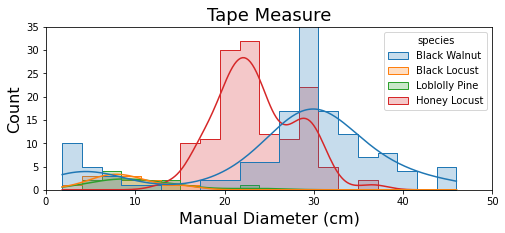

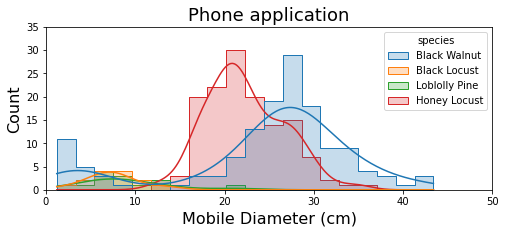

In [14]:
plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="diam", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,35])
plt.title("Tape Measure", size = 18)
plt.xlabel("Manual Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()

plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="diam_app", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,35])
plt.title("Phone application", size = 18)
plt.xlabel("Mobile Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()


In [15]:
diam_all['mae'] = diam_all['diam_app'] - diam_all['diam']
diam_all['mpe'] = (diam_all['diam_app'] - diam_all['diam']) / diam_all['diam'] * 100

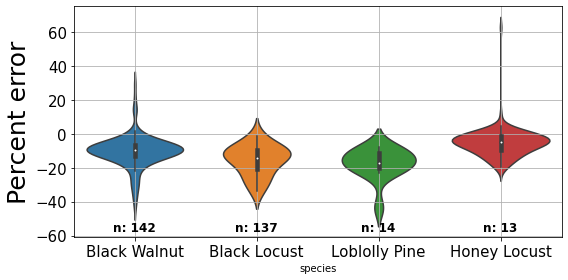

In [16]:
# Boxplot of error 
plt.figure(figsize = (8,4))
ax = sns.violinplot(x="species", y="mpe", data=diam_all)
 
# Calculate number of obs per group & median to position labels
medians =diam_all.dropna().groupby(['species'])['mpe'].mean().values
nobs = diam_all['species'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             - 57.5,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Percent error", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 

plt.tight_layout()

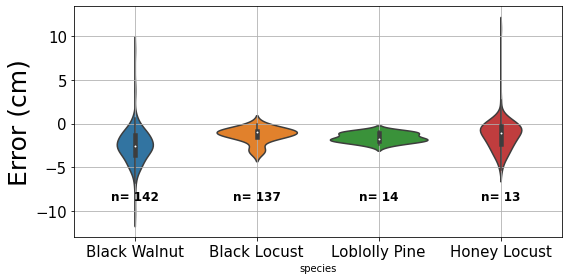

In [17]:
# Boxplot of error 
plt.figure(figsize = (8,4))
ax = sns.violinplot(x="species", y="mae", data=diam_all)
 
# Calculate number of obs per group & median to position labels
medians =diam_all.dropna().groupby(['species'])['mae'].mean().values
nobs = diam_all['species'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n= " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             - 8.75,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Error (cm)", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 

plt.tight_layout()
plt.show()

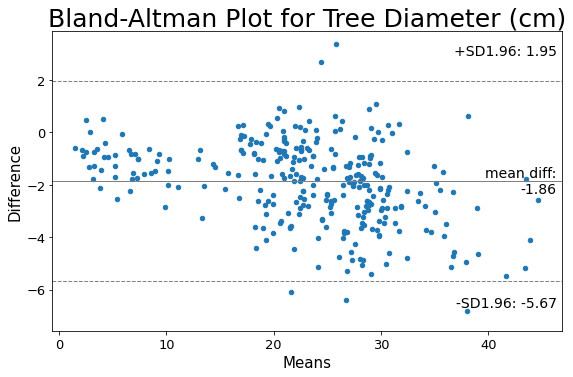

97.386 % of the data falls within 95% Diameter CI


In [18]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(diam_all['diam_app'], diam_all['diam'],  ax = ax)
plt.title("Bland-Altman Plot for Tree Diameter (cm)", size = 25)

plt.show() 

# 8
print("{} % of the data falls within 95% Diameter CI".format(str(round((100 - ((8/len(diam_all)) * 100)),3))))
